In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
#Load the data
df = pd.read_csv("data_extended_withMissing_800.csv")

df

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class,ID
0,5160.0,0.000013,120.804174,86.853334,957.0,6601.0,0.361800,0.217459,103.828754,0.051836,...,0.024471,5.596487,3.184589,71.0,40120.0,1749.278166,296102.76760,144605.0,P,id_1
1,51980.0,0.000016,115.318238,83.448681,1694.0,6998.0,0.272513,0.144880,99.383459,0.039827,...,0.018368,1.665973,0.950249,129.0,126700.0,1504.768272,278744.28500,298640.0,P,id_2
2,2600.0,0.000010,229.933997,172.761858,2333.0,5802.0,0.387020,0.181342,201.347928,0.064220,...,0.017174,4.000781,2.392521,74.0,45480.0,1431.443492,144411.70550,79025.0,P,id_3
3,2130.0,0.000010,369.403342,183.193104,1756.0,8159.0,0.556879,0.164502,276.298223,0.090408,...,0.019860,4.206746,1.613522,123.0,67945.0,1465.843329,230184.71540,181220.0,P,id_4
4,2310.0,0.000007,257.997131,111.275889,987.0,4732.0,0.266077,0.145104,184.636510,0.037528,...,0.020872,3.319036,1.680629,92.0,37285.0,1841.702561,158290.02550,72575.0,P,id_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,6160.0,0.000002,283.284183,153.728763,1377.0,11574.0,0.366125,NaN,216.876827,0.026529,...,0.021424,4.096016,3.261257,64.0,28941.0,1828.143235,NaN,95848.0,P,sdv-id-WLEXsv
870,2228.0,0.000002,290.385030,154.784786,1913.0,7822.0,0.295574,0.179651,119.896115,NaN,...,0.018413,4.468997,3.463604,74.0,37102.0,1857.734875,93129.55890,57930.0,P,sdv-id-GOfdKS
871,5366.0,0.000013,240.910721,151.717560,2042.0,7395.0,0.194077,0.178617,223.131059,0.043324,...,0.022336,6.107483,2.603519,80.0,45263.0,1741.841241,93007.03035,97231.0,P,sdv-id-cbuKnJ
872,1802.0,0.000028,310.105671,113.755988,1522.0,7265.0,0.138112,0.155182,270.964841,0.035004,...,0.020141,4.536510,3.075406,106.0,38867.0,1625.530614,188847.46926,33837.0,P,sdv-id-rVzTeU


In [3]:
#Encoding dummy variables
df_dummies = pd.get_dummies(df["class"], drop_first=True)

#Split features and target
X = df.drop(["class", "ID"], axis=1).values
y = df_dummies["P"].values

In [4]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=105)

print("Missing Count Before:", pd.DataFrame(X_train).isnull().sum().sum())

#Preprocessing
preprocessor = [("imputer", SimpleImputer(strategy="median")), # fill missing data with median
                ("scaler", StandardScaler(with_mean=False))] # standardized X without the mean

preprocessing_pipeline = Pipeline(preprocessor)

X_train_pre = preprocessing_pipeline.fit_transform(X_train)
X_test_pre = preprocessing_pipeline.transform(X_test)

print("Missing Count After: ", pd.DataFrame(X_train_pre).isnull().sum().sum())


Missing Count Before: 3156
Missing Count After:  0


In [ ]:
#Logistic Lasso Regression to look for data leakage
from sklearn.linear_model import LogisticRegression

names = df.drop(["class", "ID"], axis=1).columns

#Logistic Regression fit with Lasso(l1) as penalty for non-predictors
logreg = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000)
logreg.fit(X_train_pre, y_train)
coef = logreg.coef_[0]

#DataFrame conversion for readability
coef_df = pd.DataFrame({"Feature": names, "Coefficient": coef})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
coef_df.head()

#display(coef_df.style.set_caption("Logistic Lasso Coefficients").format(precision=3))

#There seems to be no data leakage, only two variables projected a reasonably high 
#predictive capability was seen, which upon closer inspection, seems to make sense.


,Feature,Coefficient
53,total_time3,1.045975
138,mean_speed_on_paper8,-1.027503
437,max_y_extension25,0.787427
38,gmrt_in_air3,0.669603
117,mean_jerk_in_air7,-0.593143


## On the notion of the Models Used in this Project (Semi-AI Assisted)

There are multiple machine learning models that can be used in predicting Alzheimer's Disease (AD) from a person's handwriting. But in this project I opted to choose this 13 models for initial testing for the following reasons: 

# Logistic/Statistical Models 
1. **Logistic Regression**: Serves as a baseline to test whether handwriting features have a simple linear relationship with Alzheimer’s risk.
2. **Linear Discriminant Analysis (LDA)**: Useful if Alzheimer’s and healthy handwriting patterns are normally distributed, which in this case I standardized the data, providing a statistical perspective on class separation.
3. **Naive Bayes (GaussianNB)**: Can quickly model the probability that handwriting metrics (like pressure or tremor) indicate Alzheimer’s, even with small feature subsets.

### Tree-Based Models
4. **Decision Tree**: Easily interpretable for clinicians to see which handwriting traits are most important for AD classification
5. **Random Forest**: Handles noisy handwriting features better by averaging many trees, reducing misclassification risk from variability in patients’ motor control.
6. **ExtraTrees**: Adds randomness to better capture complex handwriting irregularities common in Alzheimer’s patients while avoiding overfitting.
7. **Gradient Boosting**: Learns subtle sequential corrections in handwriting patterns, such as slight deterioration in speed or jerkiness, improving predictive power.

### Distance-Based/Kernel Models
8. **K-Nearest Neighbors (KNN)**: Compares each patient’s handwriting directly to others; Alzheimer’s patients with similar movement patterns can be grouped effectively.
9. **Support Vector Machine (SVM)**: Finds clear separating boundaries in high-dimensional handwriting features, ideal if Alzheimer’s handwriting shows distinct but complex deviations.

### Neural Networks
10. **MLP (Multi-Layer Perceptron)**: Captures hidden, non-linear relationships between handwriting features that might jointly indicate Alzheimer’s.

### Gradient Boosting Variants (Newer Technology)
11. **XGBoost**: Well-suited for detecting subtle handwriting anomalies by building strong models from weak patterns, robust for medical tabular data.
12. **LightGBM**: Scales well with large synthetic data (10k+), making it efficient for high-dimensional handwriting features while preserving accuracy.




In [5]:
# Model Packages
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
# Define the sklearn models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),  
    "GaussianNB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "ExtraTrees": ExtraTreesClassifier(), 
    "Gradient Boosting": GradientBoostingClassifier(), 
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(), 
    "KNN": KNeighborsClassifier(), 
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(max_iter=500)
}

#Hyperparameters for optimized score (AI Assissted)
parameters = {
    "Logistic Regression": {
        "clf__C":np.logspace(-3, 3, 10), 
        "clf__solver":["liblinear", "lbfgs"]
    }, 
    "Decision Tree": {
        "clf__max_depth": [None, 5, 10, 20, 30, 50],
        "clf__min_samples_split": [2, 5, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4]
    },
        "Random Forest": {
        "clf__n_estimators": [100, 200, 500, 1000],
        "clf__max_depth": [None, 10, 20, 30, 50],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    },
        "ExtraTrees": {
        "clf__n_estimators": [100, 200, 500, 1000],
        "clf__max_depth": [None, 10, 20, 30, 50],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "clf__n_estimators": [100, 200, 500],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__max_depth": [3, 5, 7]
    },
    "XGBoost": {
        "clf__n_estimators": [200, 500, 800],
        "clf__max_depth": [3, 5, 7, 10],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    },
    "LightGBM": {
        "clf__n_estimators": [200, 500, 800],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__num_leaves": [31, 50, 100, 200],
        "clf__max_depth": [-1, 10, 20, 30]
    },
    "KNN": {
        "clf__n_neighbors": list(range(1, 21)),
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2]   
    },
    "SVM": {
        "clf__C": [0.01, 0.1, 1, 10, 100],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": [0.001, 0.01, 0.1, 1, "scale"]
    },
    "MLP": {
        "clf__hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
        "clf__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
        "clf__learning_rate_init": [0.001, 0.01],
        "clf__max_iter": [500]
    }
}

In [7]:
#Define K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=105)

#Store results
results = []
best_estimate = []

# Loop through all the models
for model_name, model in models.items():

    # Simple pipeline with 'clf' placeholder
    pipeline = Pipeline([
        ("clf", model)
    ])
    
    hyp_params = parameters.get(model_name, {}) # Get parameters from the parameters dict 
    
    if hyp_params: # Check if parameters exists for the model
        #Implement RandomizedSearchCV for fine tuning
        df_cv = RandomizedSearchCV(
            pipeline, 
            param_distributions=hyp_params, 
            n_iter=20, 
            cv=kf,
            n_jobs=-1,
            scoring = 'f1_macro'
        )
        df_cv.fit(X_train_pre, y_train)
        pipeline = df_cv.best_estimator_ #Redefine pipeline to use the best estimator done by RandomSearchCV
        best_estimate.append({"Model": model_name, "Parameter": pipeline, "Score": df_cv.best_score_})
    else: 
        pipeline.fit(X_train_pre, y_train) #For models without parameters
    
    #Prediction and Evaluation of the Models
    y_pred = pipeline.predict(X_test_pre)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    #Extracting recall and f1 score
    f1_score = report["macro avg"]["f1-score"]
    recall = report["macro avg"]["recall"]

    results.append({
        "Model": model_name, 
        "Pipeline": pipeline, 
        "class_report": report, 
        "confusion matrix": cm,
        "f1 macro": f1_score,  
        "recall macro": recall,
        "y_pred": y_pred
        })
    

c:\Users\Gian\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:07:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 503, number of negative: 196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97019
[LightGBM] [Info] Number of data points in the train set: 699, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.719599 -> initscore=0.942476
[LightGBM] [Info] Start training from score 0.942476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\Gian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\Gian\AppData\Local\Temp\ipykernel_22056\3429039644.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_summary, x="Model", y="F1 Macro", palette="tab20")


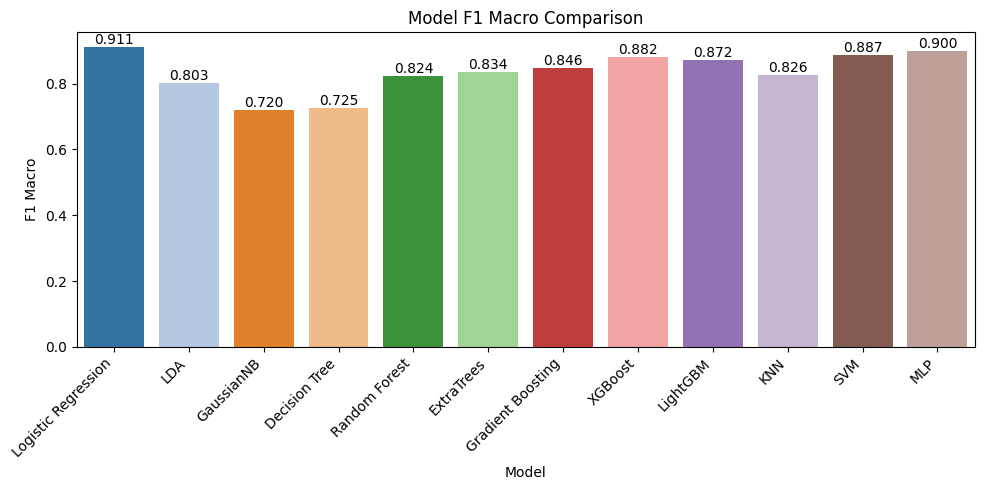

C:\Users\Gian\AppData\Local\Temp\ipykernel_22056\3429039644.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_summary, x="Model", y="Recall Macro", palette="tab20")


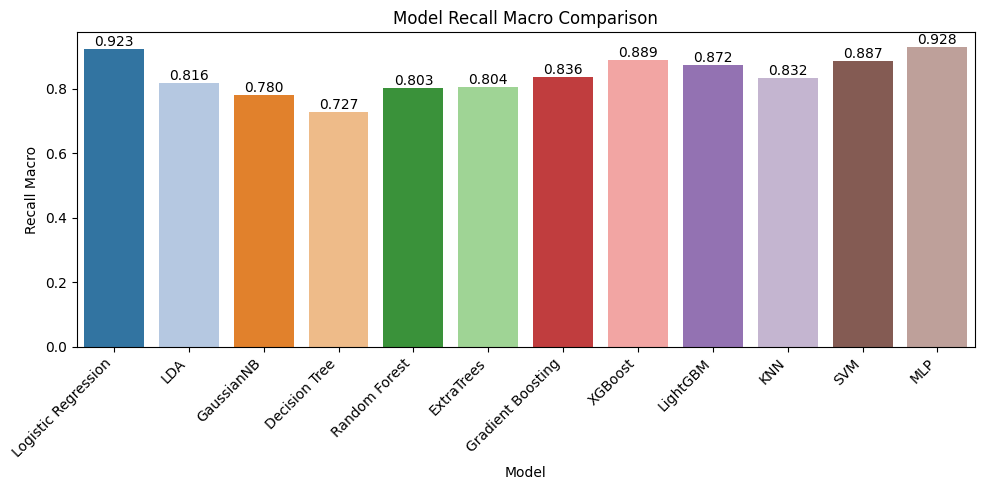

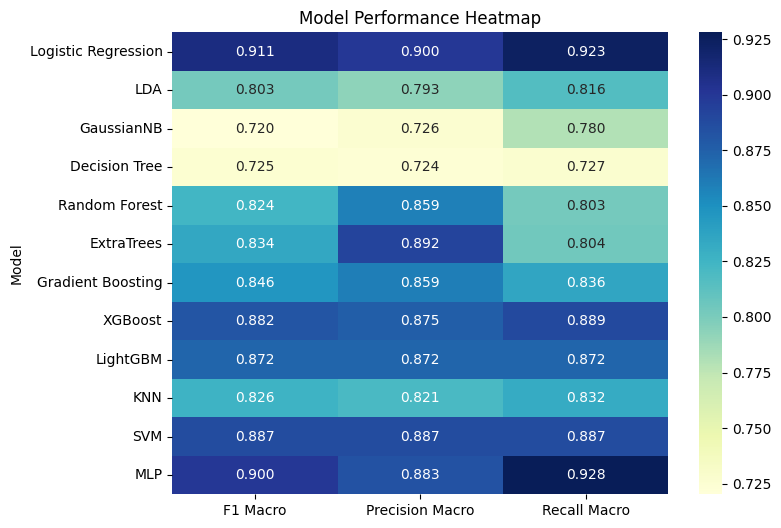

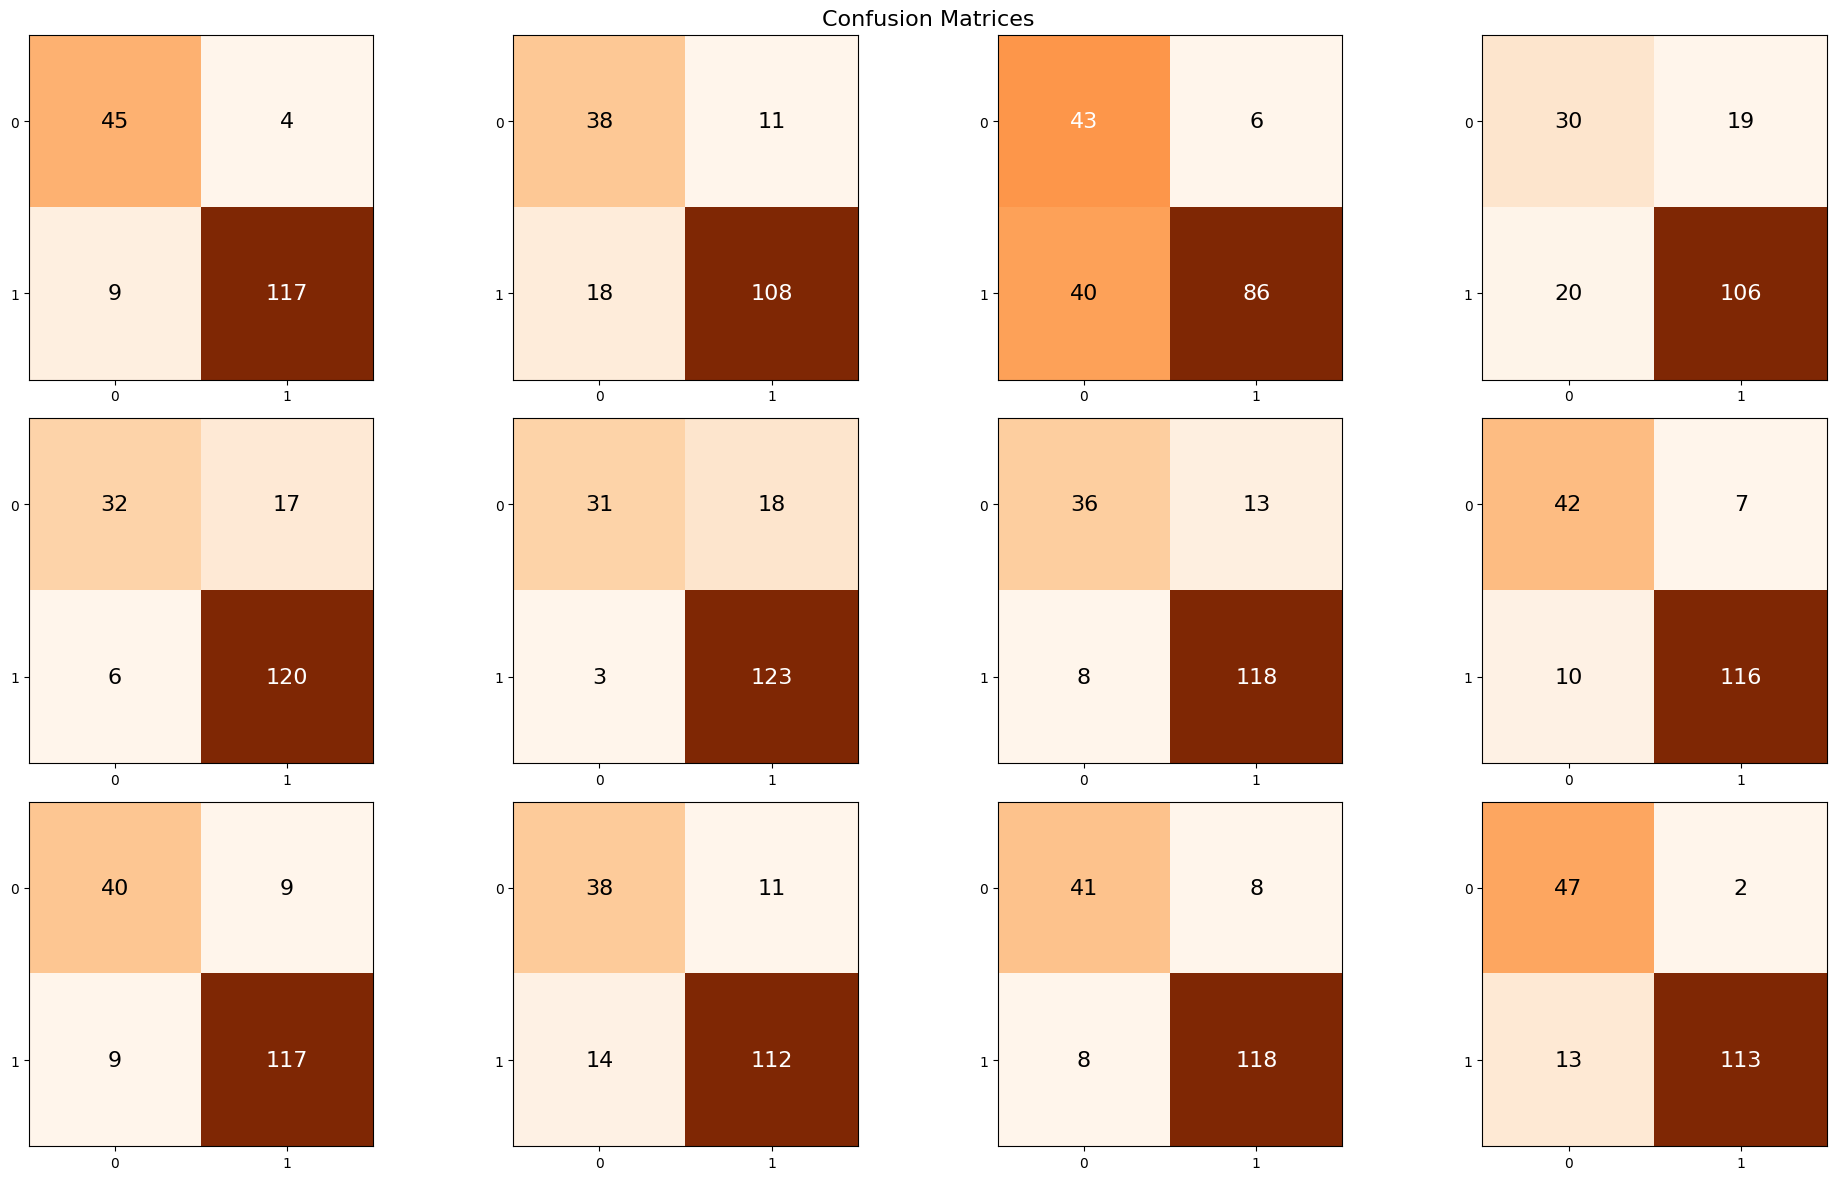

,Model,Parameter,Score
0,Logistic Regression,"Pipeline(steps=[('clf', LogisticRegression(C=np.float64(215.44346900318823), max_iter=1000))])",0.879
1,Decision Tree,"Pipeline(steps=[('clf', DecisionTreeClassifier(max_depth=10, min_samples_leaf=4))])",0.738
2,Random Forest,"Pipeline(steps=[('clf', RandomForestClassifier(max_depth=30, n_estimators=200))])",0.830
3,ExtraTrees,"Pipeline(steps=[('clf', ExtraTreesClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200))])",0.830
4,Gradient Boosting,"Pipeline(steps=[('clf', GradientBoostingClassifier(learning_rate=0.05))])",0.840
5,XGBoost,"Pipeline(steps=[('clf', XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.8, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=7, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=800, n_jobs=None, num_parallel_tree=None, ...))])",0.878
6,LightGBM,"Pipeline(steps=[('clf', LGBMClassifier(learning_rate=0.05, max_depth=20, n_estimators=500))])",0.862
7,KNN,"Pipeline(steps=[('clf', KNeighborsClassifier(n_neighbors=18, p=1))])",0.854
8,SVM,"Pipeline(steps=[('clf', SVC(C=0.01, gamma=1, kernel='linear', probability=True))])",0.849
9,MLP,"Pipeline(steps=[('clf', MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500))])",0.876


In [14]:
# Printing out results in pandas DF format 
df_summary = pd.DataFrame([
    {"Model": result["Model"], 
     "F1 Macro": result["f1 macro"],
     "Precision Macro": result["class_report"]["macro avg"]["precision"], 
     "Recall Macro":result["recall macro"],
     }
     for result in results
])

#Bar Plot of F1 Macro
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_summary, x="Model", y="F1 Macro", palette="tab20")
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.title("Model F1 Macro Comparison")
plt.tight_layout()
plt.show()

#Bar Plot of Recall Macro
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_summary, x="Model", y="Recall Macro", palette="tab20")
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.title("Model Recall Macro Comparison")
plt.tight_layout()
plt.show()

#Heat Map
plt.figure(figsize=(8,6))
sns.heatmap(df_summary.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".3f", cbar=True)
plt.title("Model Performance Heatmap")
plt.show()

#Generating heat maps for plotting the confusion matrix 
figure, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.ravel()

for i, result in enumerate(results):
    cm = result["confusion matrix"]
    img = axes[i].imshow(cm, interpolation="nearest", cmap=plt.cm.Oranges)

    #Set confusion matrix values
    axes[i].set_xticks(np.arange(cm.shape[1]))
    axes[i].set_yticks(np.arange(cm.shape[0]))

    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            axes[i].text(
                col, row, f"{cm[row, col]}", 
                ha="center", va="center", fontsize=16,
                color="black" if cm[row, col] < cm.max()/2 else "white"
            )

plt.suptitle("Confusion Matrices", fontsize = 16)
plt.tight_layout()
plt.show()

#Data Summary
from IPython.display import display
df_best = pd.DataFrame(best_estimate)
display(df_best.style.set_caption("Model Performance Summary")
                       .format(precision=3))
#print(df_best)
